<a href="https://colab.research.google.com/github/ram130849/ML_Algorithms/blob/main/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
import torch
import numpy as np
import torch.nn as nn
from tqdm import tqdm
from torchvision.utils import make_grid,save_image
import matplotlib.pyplot as plt

In [6]:
cuda = False
device = 'cuda' if cuda else 'cpu'
dataset_path = '~/datasets'
lr = 1e-3
epochs = 30
batch_size = 100

input_size = 784
hidden_size = 400
output_size = 200

In [4]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


In [7]:
mnist_transform = transforms.Compose([transforms.ToTensor(),])
kwargs = {'num_workers':1,'pin_memory':False}

train_dataset = MNIST(dataset_path,train=True,transform=mnist_transform,download=True)
test_dataset = MNIST(dataset_path,train=False,transform=mnist_transform,download=True)

train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=True,**kwargs) 
test_loader = DataLoader(dataset=test_dataset,batch_size=batch_size,shuffle=False,**kwargs)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /root/datasets/MNIST/raw/train-images-idx3-ubyte.gz to /root/datasets/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /root/datasets/MNIST/raw/train-labels-idx1-ubyte.gz to /root/datasets/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /root/datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/datasets/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /root/datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/datasets/MNIST/raw



In [26]:
class Encoder(nn.Module):
  def __init__(self,input_size,hidden_size,output_size):
      super(Encoder,self).__init__()
      self.FC_input = nn.Linear(input_size,hidden_size)
      self.FC_input2 = nn.Linear(hidden_size,hidden_size)
      self.FC_mean = nn.Linear(hidden_size,output_size)
      self.FC_var = nn.Linear(hidden_size,output_size)
      
      self.leaky_relu = nn.LeakyReLU(0.2)
      
      
      self.training=True

  def forward(self,x):
      h_dim = self.leaky_relu(self.FC_input(x))
      h_dim = self.leaky_relu(self.FC_input2(h_dim))
      mean = self.FC_mean(h_dim)
      var = self.FC_var(h_dim)

      return mean,var

In [27]:
class Decoder(nn.Module):
  def __init__(self,latent_size,hidden_size,output_size):
      super(Decoder,self).__init__()
      self.FC_hidden1 = nn.Linear(latent_size,hidden_size) 
      self.FC_hidden2 = nn.Linear(hidden_size,hidden_size)
      self.FC_output = nn.Linear(hidden_size,output_size)
      self.leaky_relu = nn.LeakyReLU(0.2)

  def forward(self,x):
      h_dim = self.leaky_relu(self.FC_hidden1(x))
      h_dim = self.leaky_relu(self.FC_hidden2(h_dim))

      x_hat = torch.sigmoid(self.FC_output(h_dim))

      return x_hat

In [28]:
class VAE(nn.Module):
  def __init__(self,Encoder,Decoder):
    super(VAE,self).__init__()
    self.encoder = Encoder
    self.decoder = Decoder

  def reparametrization(self,mean,var):
    epsilon = torch.randn_like(var).to(device)
    z = mean + var*epsilon
    return z
  
  def forward(self,x):
    mean,log_var = self.encoder(x)
    h_dim = self.reparametrization(mean,torch.exp(0.5*log_var))
    x_hat = self.decoder(h_dim)
    return x_hat,mean,log_var


In [29]:
encoder = Encoder(input_size=input_size,hidden_size=hidden_size,output_size=output_size)
decoder = Decoder(latent_size=output_size,hidden_size=hidden_size,output_size=input_size)
vae_model = VAE(Encoder=encoder,Decoder=decoder).to(device)

In [30]:
from torch.optim import Adam

BCE_loss = nn.BCELoss()

def loss_function(x,x_hat,mean,log_var):
    reconstruction_loss = nn.functional.binary_cross_entropy(x_hat,x,reduction='sum')
    KLD = -0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())
    return reconstruction_loss+KLD

optimizer = Adam(vae_model.parameters(),lr=lr)

In [32]:
vae_model.train()

for epoch in range(epochs):
    overall_loss = 0
    for batch_idx, (x,_) in enumerate(train_loader):
        # https://stackoverflow.com/questions/42479902/what-does-view-do-in-pytorch - view function explanation
        x = x.view(batch_size,input_size)
        x = x.to(device)
        
        optimizer.zero_grad()
        
        x_hat,mean,log_var = vae_model(x)
        # print(x,x_hat)
        loss = loss_function(x,x_hat,mean,log_var)

        overall_loss+= loss.item()
        loss.backward()
        optimizer.step()
    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx*batch_size))
    
print("Finish!!")

	Epoch 1 complete! 	Average Loss:  105.73652958381156
	Epoch 2 complete! 	Average Loss:  105.1571840437187
	Epoch 3 complete! 	Average Loss:  104.52546920648999
	Epoch 4 complete! 	Average Loss:  104.08223042636165
	Epoch 5 complete! 	Average Loss:  103.69502641120617
	Epoch 6 complete! 	Average Loss:  103.25533064547683
	Epoch 7 complete! 	Average Loss:  102.86741727749374
	Epoch 8 complete! 	Average Loss:  102.59770962672162
	Epoch 9 complete! 	Average Loss:  102.37747978401502
	Epoch 10 complete! 	Average Loss:  102.12308231818656
	Epoch 11 complete! 	Average Loss:  101.90137869756886
	Epoch 12 complete! 	Average Loss:  101.74487053618009
	Epoch 13 complete! 	Average Loss:  101.54210679909224
	Epoch 14 complete! 	Average Loss:  101.37227328751044
	Epoch 15 complete! 	Average Loss:  101.26668751304257
	Epoch 16 complete! 	Average Loss:  101.11992071747183
	Epoch 17 complete! 	Average Loss:  101.02683001943343
	Epoch 18 complete! 	Average Loss:  100.82064836250521
	Epoch 19 complete! 

In [35]:
vae_model.eval()

with torch.no_grad():
    for batch_idx, (x,_) in enumerate(tqdm(test_loader)):
        x = x.view(batch_size,input_size)
        x = x.to(device)

        x_hat,_,_ = vae_model(x)

        break


  0%|          | 0/100 [00:00<?, ?it/s]


In [34]:
def show_image(x,idx):
    x = x.view(batch_size,28,28)

    fig = plt.figure()
    plt.imshow(x[idx].cpu().numpy())

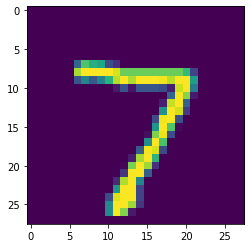

In [36]:
show_image(x, idx=0)

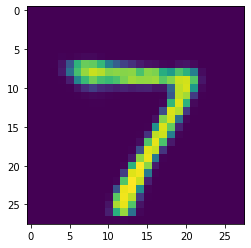

In [39]:
show_image(x_hat,idx=0)

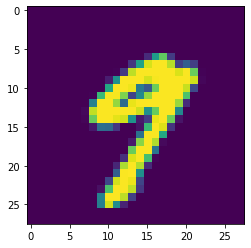

In [37]:
show_image(x, idx=20)

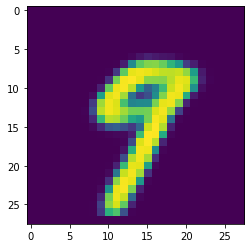

In [40]:
show_image(x_hat,idx=20)

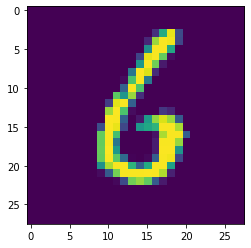

In [38]:
show_image(x, idx=50)

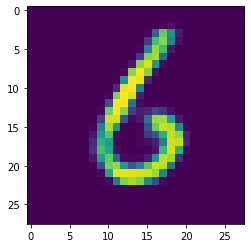

In [41]:
show_image(x_hat, idx=50)

In [42]:
# Generate image from noise vector
# Please note that this is not the correct generative process.

# Even if we don't know exact p(z|x), we can generate images from noise, since the loss function of training VAE regulates the q(z|x) (simple and tractable posteriors) must close enough to N(0, I). If q(z|x) is close to N(0, I) "enough"(but not tightly close due to posterior collapse problem), N(0, I) may replace the encoder of VAE.

# To show this, I just tested with a noise vector sampled from N(0, I) similar with Generative Adversarial Network.

In [44]:
with torch.no_grad():
    noise = torch.randn(batch_size, output_size).to(device)
    generated_images = decoder(noise)

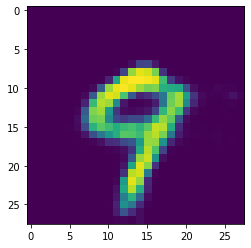

In [45]:
show_image(generated_images, idx=12)